In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import importlib
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
import h5py
from scipy.optimize import curve_fit

import utils as ut

utils_fold = "C:/Users/Pere/Documents/code/utils/"
sys.path.append(utils_fold)
import mutils as mut
from mutils.plot_utils import Figure
from mutils.plot_utils import Figure3D
importlib.reload(mut)

<module 'mutils' from 'C:\\Users/Pere/Documents/code/utils\\mutils\\__init__.py'>

In [3]:
simulation_name = 'collapsing_sphere'

sim_types = ['random_z_0_N_29999', 'regular_z_0_N_30976',  
             'regular_z_3_N_30976', 'regular_z_6_N_30976',
             'regular_z_9_N_30976']

dic_output = {sim_type: {} for sim_type in sim_types}

for sim_type in sim_types:
    output_folder = f'output_{sim_type}'
    snaps = ut.get_snapshots(f'../data/{simulation_name}/{output_folder}/')
    files = [h5py.File(snap, 'r') for snap in snaps]
    dic_output[sim_type]['files'] = files
    times = [file['Header'].attrs['Time'] for file in files]
    dic_output[sim_type]['times'] = times

    N_particles = files[0]['Header'].attrs['NumPart_Total'][1]
    dic_output[sim_type]['N'] = N_particles

C:\Users\Pere\AppData\Local\Temp\ipykernel_15064\4197926989.py:53: RuntimeWarning: divide by zero encountered in log
  projection = np.log(np.sum(hist, axis=2))


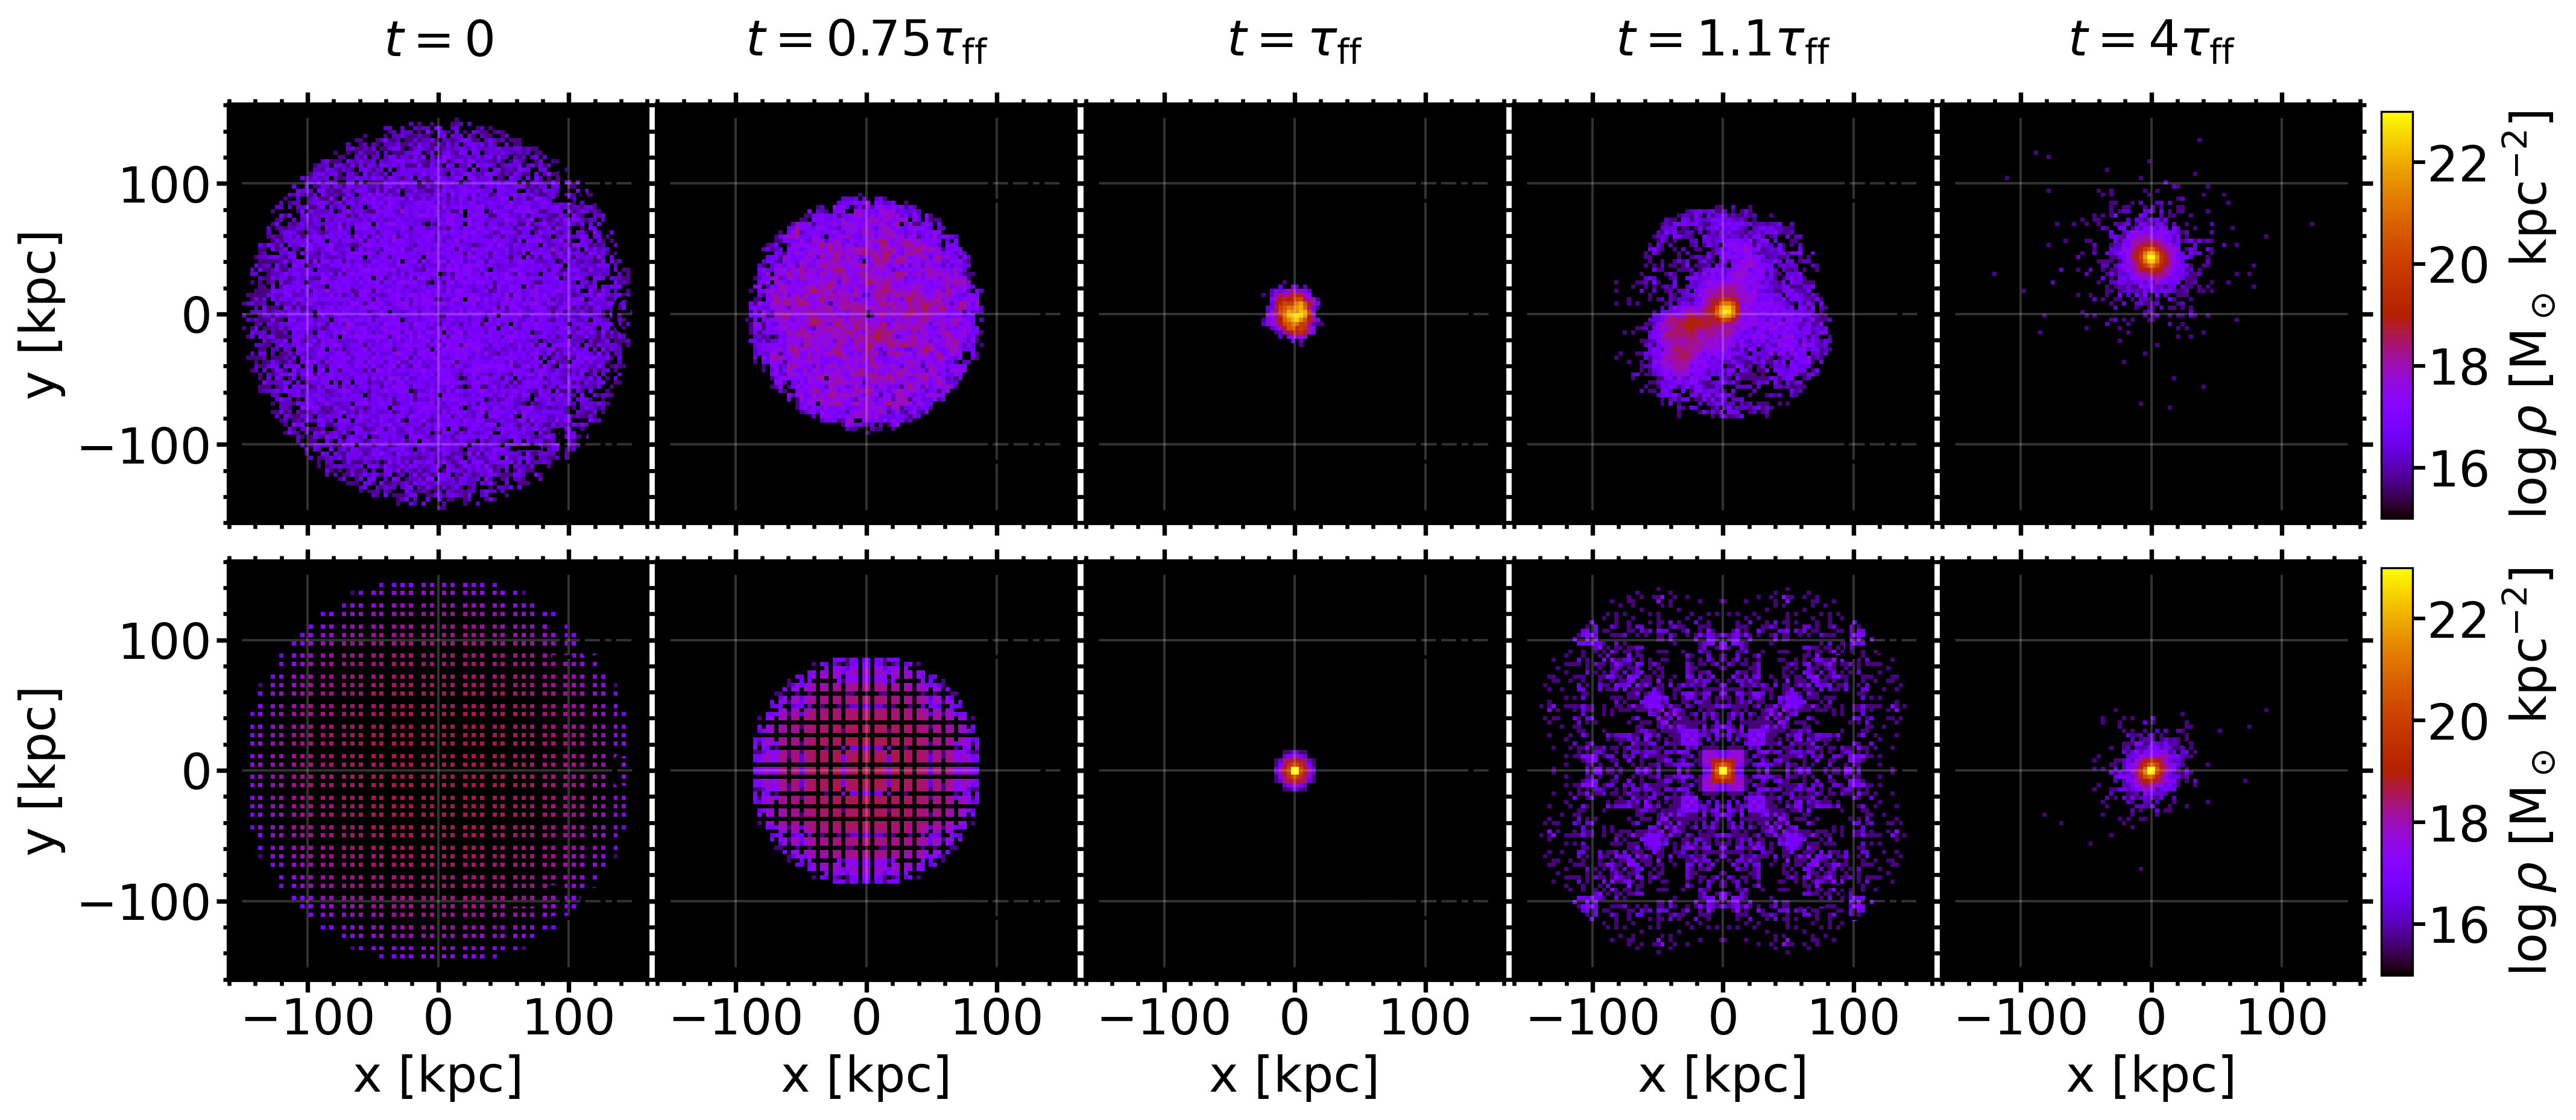

In [4]:
t_ff = 0.984

facts = [0, 0.75, 1, 1.1, 4]
times = [fact*t_ff for fact in facts]

t_ff_text = r'\tau_{\text{ff}}'
titles = ['$t=0$', f'$t=0.75{t_ff_text}$', f'$t={t_ff_text}$', f'$t=1.1{t_ff_text}$',  f'$t=4{t_ff_text}$']


J = len(times)

subplots = (2, J)
fig_size = 1920
ratio = J / 2 * 0.95
ts = 2
Fig = Figure(fig_size=fig_size, subplots=subplots, 
             ratio=ratio, theme='default', 
             wspace=0.025, hspace=0.05, grid=True,
             ts=ts)
fs = Fig.fs
axes = Fig.axes
axes_flat = Fig.axes_flat



resolution = 100
lim = 160

for i, sim_type in enumerate(sim_types[:2]):

    time_array = dic_output[sim_type]['times']

    for j, time in enumerate(times):

        ax = axes[i][j]

        idx = np.argmin(np.abs(np.array(time_array) - time))

        file = dic_output[sim_type]['files'][idx]

        PM_g4 = file['Header'].attrs['MassTable'][1]
        PM = PM_g4 * ut.M_gadget.to(u.Msun).value
        dh = 2*lim/resolution

        positions = file['PartType1']['Coordinates']

        ranges = [(-lim, lim), (-lim, lim), (-lim, lim)]

        hist, edges = np.histogramdd(positions[:, :], bins=[resolution]*3, range=ranges)

        hist = hist * PM / dh**2

        projection = np.log(np.sum(hist, axis=2))

        ax.imshow((projection.T)[::-1,:], cmap='gnuplot', 
                  extent=[-lim, lim, -lim, lim],
                  vmin=15, vmax=23
                  )

        if j == J-1:
            # add colorbar to ax
            cax = ax.inset_axes([1.05, 0.01, 0.075, 0.975])
            cax.tick_params(labelsize=ts*fs,
                            size=0.5*fs, width=0.15*fs,
                            pad=0.1*fs)
            cbar = plt.colorbar(cax=cax, mappable=ax.images[0], orientation='vertical')
            cbar.set_label(r'$\log \rho$ [M$_\odot$ kpc$^{-2}$]', fontsize=fs*ts)

        if i == 0:
            # set xticks label size equal to 2
            ax.tick_params(axis='x', labelcolor='w')

            # set title
            ax.set_title(titles[j], fontsize=fs*ts,
                         pad=2*fs)

        if i == 1:
            ax.set_xlabel('x [kpc]', fontsize=fs*ts)

        if j == 0:
            ax.set_ylabel('y [kpc]', fontsize=fs*ts)


for ax in axes_flat:
    ax.set_facecolor('black')

    # set grid color to white
    ax.grid(color='white',alpha=0.2)

savepath = f'../figures/{simulation_name}/figure_1.jpg'
Fig.save(savepath, bbox_inches='tight')

In [5]:
# lims for recursive cm computation
lims = [None, 500, 200, 100, 75, 50, 25]

dic = {}

for i, sim_type in enumerate(sim_types):

    dic[sim_type] = {}

    files = dic_output[sim_type]['files']
    N = dic_output[sim_type]['N']
    rs = np.zeros(len(files))
    rs_cm = np.zeros(len(files))
    for i, file in enumerate(files):
        positions = np.array(file['PartType1']['Coordinates'])
        cm = ut.compute_recursive_cm(positions, lims=lims)
        r_cm = np.linalg.norm(cm)
        r = np.linalg.norm(positions-cm, axis=1)
        rs[i] = np.percentile(r, 40)
        rs_cm[i] = r_cm

    dic[sim_type]['r_50'] = rs
    dic[sim_type]['r_cm'] = rs_cm

In [43]:
subplots = (1, 1)
fig_size = 1920
ratio = 1.5
ts = 2.5
Fig = Figure(fig_size=fig_size, subplots=subplots, 
             ratio=ratio, theme='default', 
             wspace=0.025, hspace=0.05, grid=True,
             ts=ts)
fs = Fig.fs
ax = Fig.axes_flat[0]
lw = 0.45

labels = ['$r_{50, \\text{rdm}}$ ($z=0$)', 
          '$r_{50, \\text{grid}}$ ($z=0$)',
          '$r_{50, \\text{grid}}$ ($z=3$)',
          '$r_{50, \\text{grid}}$ ($z=6$)',
          '$r_{50, \\text{grid}}$ ($z=9$)']

labels2 = ['$r_{\\text{cm, rdm}}$ ($z=0$)', 
          '$r_{\\text{cm, grid}}$ ($z=0$)',]

cs = ['r', 'k', 'dimgrey', 'darkgrey', 'lightgrey']
legend_elements1 = []  # To store the legend handles for the first set
legend_elements2 = []  # To store the legend handles for the second set

for i, sim_type in enumerate(sim_types):
    times = dic_output[sim_type]['times']
    times = np.array(times) / t_ff
    rs = dic[sim_type]['r_50']
    rs_cm = dic[sim_type]['r_cm']
    line1, = ax.plot(times, rs, label=labels[i], lw=lw*fs, c=cs[i])
    
    if i < 2:
        line2, = ax.plot(times, rs_cm, c=cs[i], label=labels2[i], ls='dotted', lw=1.5*lw*fs)
        legend_elements2.append(line2)
    
    legend_elements1.append(line1)

# Creating the first legend with labels
legend1 = ax.legend(handles=legend_elements1, fontsize=fs*ts*0.8, loc=(0, 1.01), ncols=3,
                    # bounding box false
                    frameon=True)
ax.add_artist(legend1)  # This is necessary to keep the first legend when the second is created

# Creating the second legend with labels2, adjust the location as needed
legend2 = ax.legend(handles=legend_elements2, fontsize=fs*ts*0.8, loc=(0.6, 0.8))
ax.add_artist(legend2)


ax.set_xlim(0, 4)
ax.set_ylim(-5, 155)
ax.set_xlabel('$t\  / \ \\tau_{\\text{ff}}$', fontsize=fs*ts*1.15)
ax.set_ylabel('$r$ [kpc]', fontsize=fs*ts*1.15)

from matplotlib.transforms import Bbox
bbox_inches = Bbox.from_bounds(0, 0, 9, 6.5)
savepath = f'../figures/{simulation_name}/figure_2.jpg'
Fig.save(savepath, bbox_inches=bbox_inches)
plt.close()

In [20]:
# lims for recursive cm computation
lims = [None, 500, 200, 100, 75, 50, 25]

t = 4
rang = 50
bins = 100

dic_profile = {}

rss = np.linspace(0, rang, bins)

for i, sim_type in enumerate(sim_types[:2]):

    density2 = np.zeros(bins-1)
    mass = np.zeros(bins)

    dic_profile[sim_type] = {}
    files = dic_output[sim_type]['files']
    times = dic_output[sim_type]['times']
    idx = np.argmin(np.abs(np.array(times) - t))
    file = files[idx]

    PM_g4 = file['Header'].attrs['MassTable'][1]
    PM = PM_g4 * ut.M_gadget.to(u.Msun).value

    positions = np.array(file['PartType1']['Coordinates'])
    cm = ut.compute_recursive_cm(positions, lims=lims)
    if i==1:
        cm = np.array([0,0,0])
    r = np.linalg.norm(positions-cm, axis=1)
    hist, edges = np.histogram(r, bins=bins, range=(0, rang), density=False)
    rs = (edges[:-1] + edges[1:]) / 2
    dr = edges[1] - edges[0]

    for j in range(len(rss)-1):
        n = np.sum((r >= rss[j]) & (r < rss[j+1]))
        vol = 4/3 * np.pi * (rss[j+1]**3 - rss[j]**3)
        density2[j] = n * PM / vol

    for j in range(len(rss)):
        n = np.sum(r < rss[j])
        mass[j] = n * PM

    vol_el = 4*np.pi*(edges[1:]**3 - edges[:-1]**3) / 3

    density = hist / vol_el * PM
    
    dic_profile[sim_type]['r'] = edges
    dic_profile[sim_type]['rs'] = rss

    dic_profile[sim_type]['density'] = density
    dic_profile[sim_type]['density2'] = density2
    dic_profile[sim_type]['mass'] = mass

In [51]:
ts = 2.2
Fig = Figure(fig_size=1080, subplots=(2,1), ratio=1.5, theme='default', ts=ts, height_ratios=[1, 0.4], hspace=0)
ax = Fig.axes_flat[0]
ax2 = Fig.axes_flat[1]
fs = Fig.fs
lw = 0.2
cs = ['r', 'k']
leg_el_1, leg_el_2, leg_el_3 = [], [], []
labels1 = ['$\\rho_{\\text{rdm}}$ ($z=0$)', '$\\rho_{\\text{grid}}$ ($z=0$)',]
labels2 = ['NFW fit $(\\rho_{\\text{rdm}})$', 'NFW fit $(\\rho_{\\text{grid}})$',]

chi2s = []
for i, sim_type in enumerate(sim_types[:2]):
    r = dic_profile[sim_type]['rs']
    mass = dic_profile[sim_type]['mass']
    #ax.plot(r, mass, lw=lw*fs, c=cs[i])

    rho_guess = mass[-1] / (4/3 * np.pi * r[-10]**3)
    r_guess = r[-1]

    popt, pcov = curve_fit(ut.NFW_mass_profile, r, mass, p0=[rho_guess, r_guess])
    print(popt)
    nfw_profile_arr = ut.NFW_density_profile(r[1:], *popt)
    line2, = ax.plot(r[1:], nfw_profile_arr, lw=lw*fs, c=cs[i], ls='dotted', label=labels2[i])
    leg_el_2.append(line2)

    density = dic_profile[sim_type]['density']
    line1, = ax.plot(r[1:], density[1:], lw=lw*fs, c=cs[i], label=labels1[i])
    leg_el_1.append(line1)

    residual = (density[1:] - nfw_profile_arr)/nfw_profile_arr
    line3, = ax2.plot(r[1:], residual, lw=lw*fs, c=cs[i])

    x0, y0 = 0.025, 0.15
    dx, dy = .3, .13

    num1 = ut.format_scientific(popt[0], 2)
    ax.text(x0+i*dx, y0, f'$\\rho_s =$ {num1}',
            fontsize=fs*ts, ha='left', va='center', transform=ax.transAxes, color=cs[i])
    
    num2 = ut.format_scientific(popt[1], 2)
    ax.text(x0+i*dx, y0 - dy, f'$r_s =$ {num2}',
            fontsize=fs*ts, ha='left', va='bottom', transform=ax.transAxes, color=cs[i])
    
    # chi_2 = np.sum(residual**2 / density**2) 
    # chi2s.append(chi_2)
    # chi2_num = ut.format_scientific(chi_2, 2)
    # ax2.text(x0+i*dx*0.6, y0, f'$\\chi^2 =$ {chi2_num}',
    #         fontsize=fs*ts, ha='left', va='center', transform=ax2.transAxes, color=cs[i])

ax.tick_params(axis='x', labelcolor='w')
for ax_ in [ax, ax2]:
    ax_.set_xscale('log')
    ax.set_yscale('log')
    ax_.set_xlim(r[1], r[-1])

sc = 1.15
ax.set_ylabel(r'$\log \rho$ [$\text{M}_{\! \odot} \, \text{kpc}^{-3}$]', fontsize=fs*ts*sc)
ax2.set_ylabel(r'$(\rho - \rho_{\text{fit}})/\rho_{\text{fit}}$', fontsize=fs*ts*sc)
ax2.set_xlabel('$r$ [kpc]', fontsize=fs*ts*sc)
# [$\text{M}_{\! \odot} \, \text{kpc}^{-3}$]

x0, y0 = 0.69, 0.75
dx = 0.35
legend1 = ax.legend(handles=leg_el_1, fontsize=fs*ts, loc=(x0, y0))
ax.add_artist(legend1)  

legend2 = ax.legend(handles=leg_el_2, fontsize=fs*ts, loc=(x0-dx, y0))
ax.add_artist(legend2)  

bbox_inches = 'tight'
savepath = f'../figures/{simulation_name}/figure_3.jpg'
Fig.save(savepath, bbox_inches=bbox_inches)
plt.close()

[5.81258904e+11 2.87246016e-01]
[2.28579681e+14 3.44974684e-02]


In [42]:
E_g4 = ut.M_gadget * ut.L_gadget**2 / ut.T_gadget**2
E_g4 = E_g4.to(u.J).value

ts = 2
Fig = Figure(fig_size=1920, subplots=(2,1), ratio=1.5, theme='default', ts=ts, height_ratios=[1, 0.4], hspace=0)
ax = Fig.axes_flat[0]
ax2 = Fig.axes_flat[1]
fs = Fig.fs
lw = 0.3

labels = ['rdm ($z=0$)', 
          'grid ($z=0$)',
          'grid ($z=3$)',
          'grid ($z=6$)',
          'grid ($z=9$)',]

x1, y1 = 0.3, 0.1
dx1 = 0.11
leg_el_1, leg_el_2, leg_el_3 = [], [], []
cs = ['r', 'k', 'dimgrey', 'darkgrey', 'lightgrey']
for i, sim_type in enumerate(sim_types[:]):
    path_energy_data = f'../data/{simulation_name}/output_{sim_type}/energy.txt'

    files = dic_output[sim_type]['files']
    times = dic_output[sim_type]['times']

    energy_data = np.loadtxt(path_energy_data)
    potential_energy = energy_data[:, 2] * E_g4 / 1e52
    kinetic_energy = energy_data[:, 3] * E_g4 / 1e52
    total_energy = potential_energy + kinetic_energy

    line1, = ax.plot(times, potential_energy, lw=lw*fs, c=cs[i], label=labels[i])
    leg_el_1.append(line1)
    ax.plot(times, kinetic_energy, lw=lw*fs, c=cs[i], ls='--')
    ax2.plot(times, total_energy, lw=lw*fs, c=cs[i])

    val = np.abs(potential_energy[-1]) / kinetic_energy[-1]

    coma = ',' if i < 4 else ''

    ax.text(x1+dx1*1.5+dx1*i, y1, f'${val:0.2f}${coma}', fontsize=fs*ts, 
            ha='left', va='center', transform=ax.transAxes, color=cs[i])


ax.text(x1, y1, r'$[|U|/K]_{\text{eq}}=$', fontsize=fs*ts, ha='left', va='center', transform=ax.transAxes)


l1, = ax.plot([],[], color='k', ls='-', lw=lw*fs, label='Potential energy')
l2, = ax.plot([],[], color='k', ls='--', lw=lw*fs, label='Kinetic energy')
leg_el2 = [l1, l2]

for ax_ in [ax, ax2]:
    ax_.set_xlim(0, 4)
ax.tick_params(axis='x', labelcolor='w')

ax.set_ylabel(r' $E \ $  [$10^{52}$ J]', fontsize=fs*ts)
ax2.set_ylabel(r'$E_{\text{tot}} \ $  [$10^{52}$ J]', fontsize=fs*ts)
ax2.set_xlabel(r'$t \ / \ \tau_{\text{ff}}$ ', fontsize=fs*ts)

x0, y0 = 0, 1.025
legend1 = ax.legend(handles=leg_el_1, fontsize=fs*ts*0.85, loc=(x0, y0), ncols=3)
ax.add_artist(legend1)

legend2 = ax.legend(handles=leg_el2, fontsize=fs*ts*0.85, loc=(0.4, 0.89), ncol=2)
ax.add_artist(legend2)

from matplotlib.transforms import Bbox
bbox_inches = Bbox.from_bounds(0, 0, 9, 6.5)
savepath = f'../figures/{simulation_name}/figure_4.jpg'
Fig.save(savepath, bbox_inches=bbox_inches)
plt.close()

NameError: name 'dic_profile' is not defined

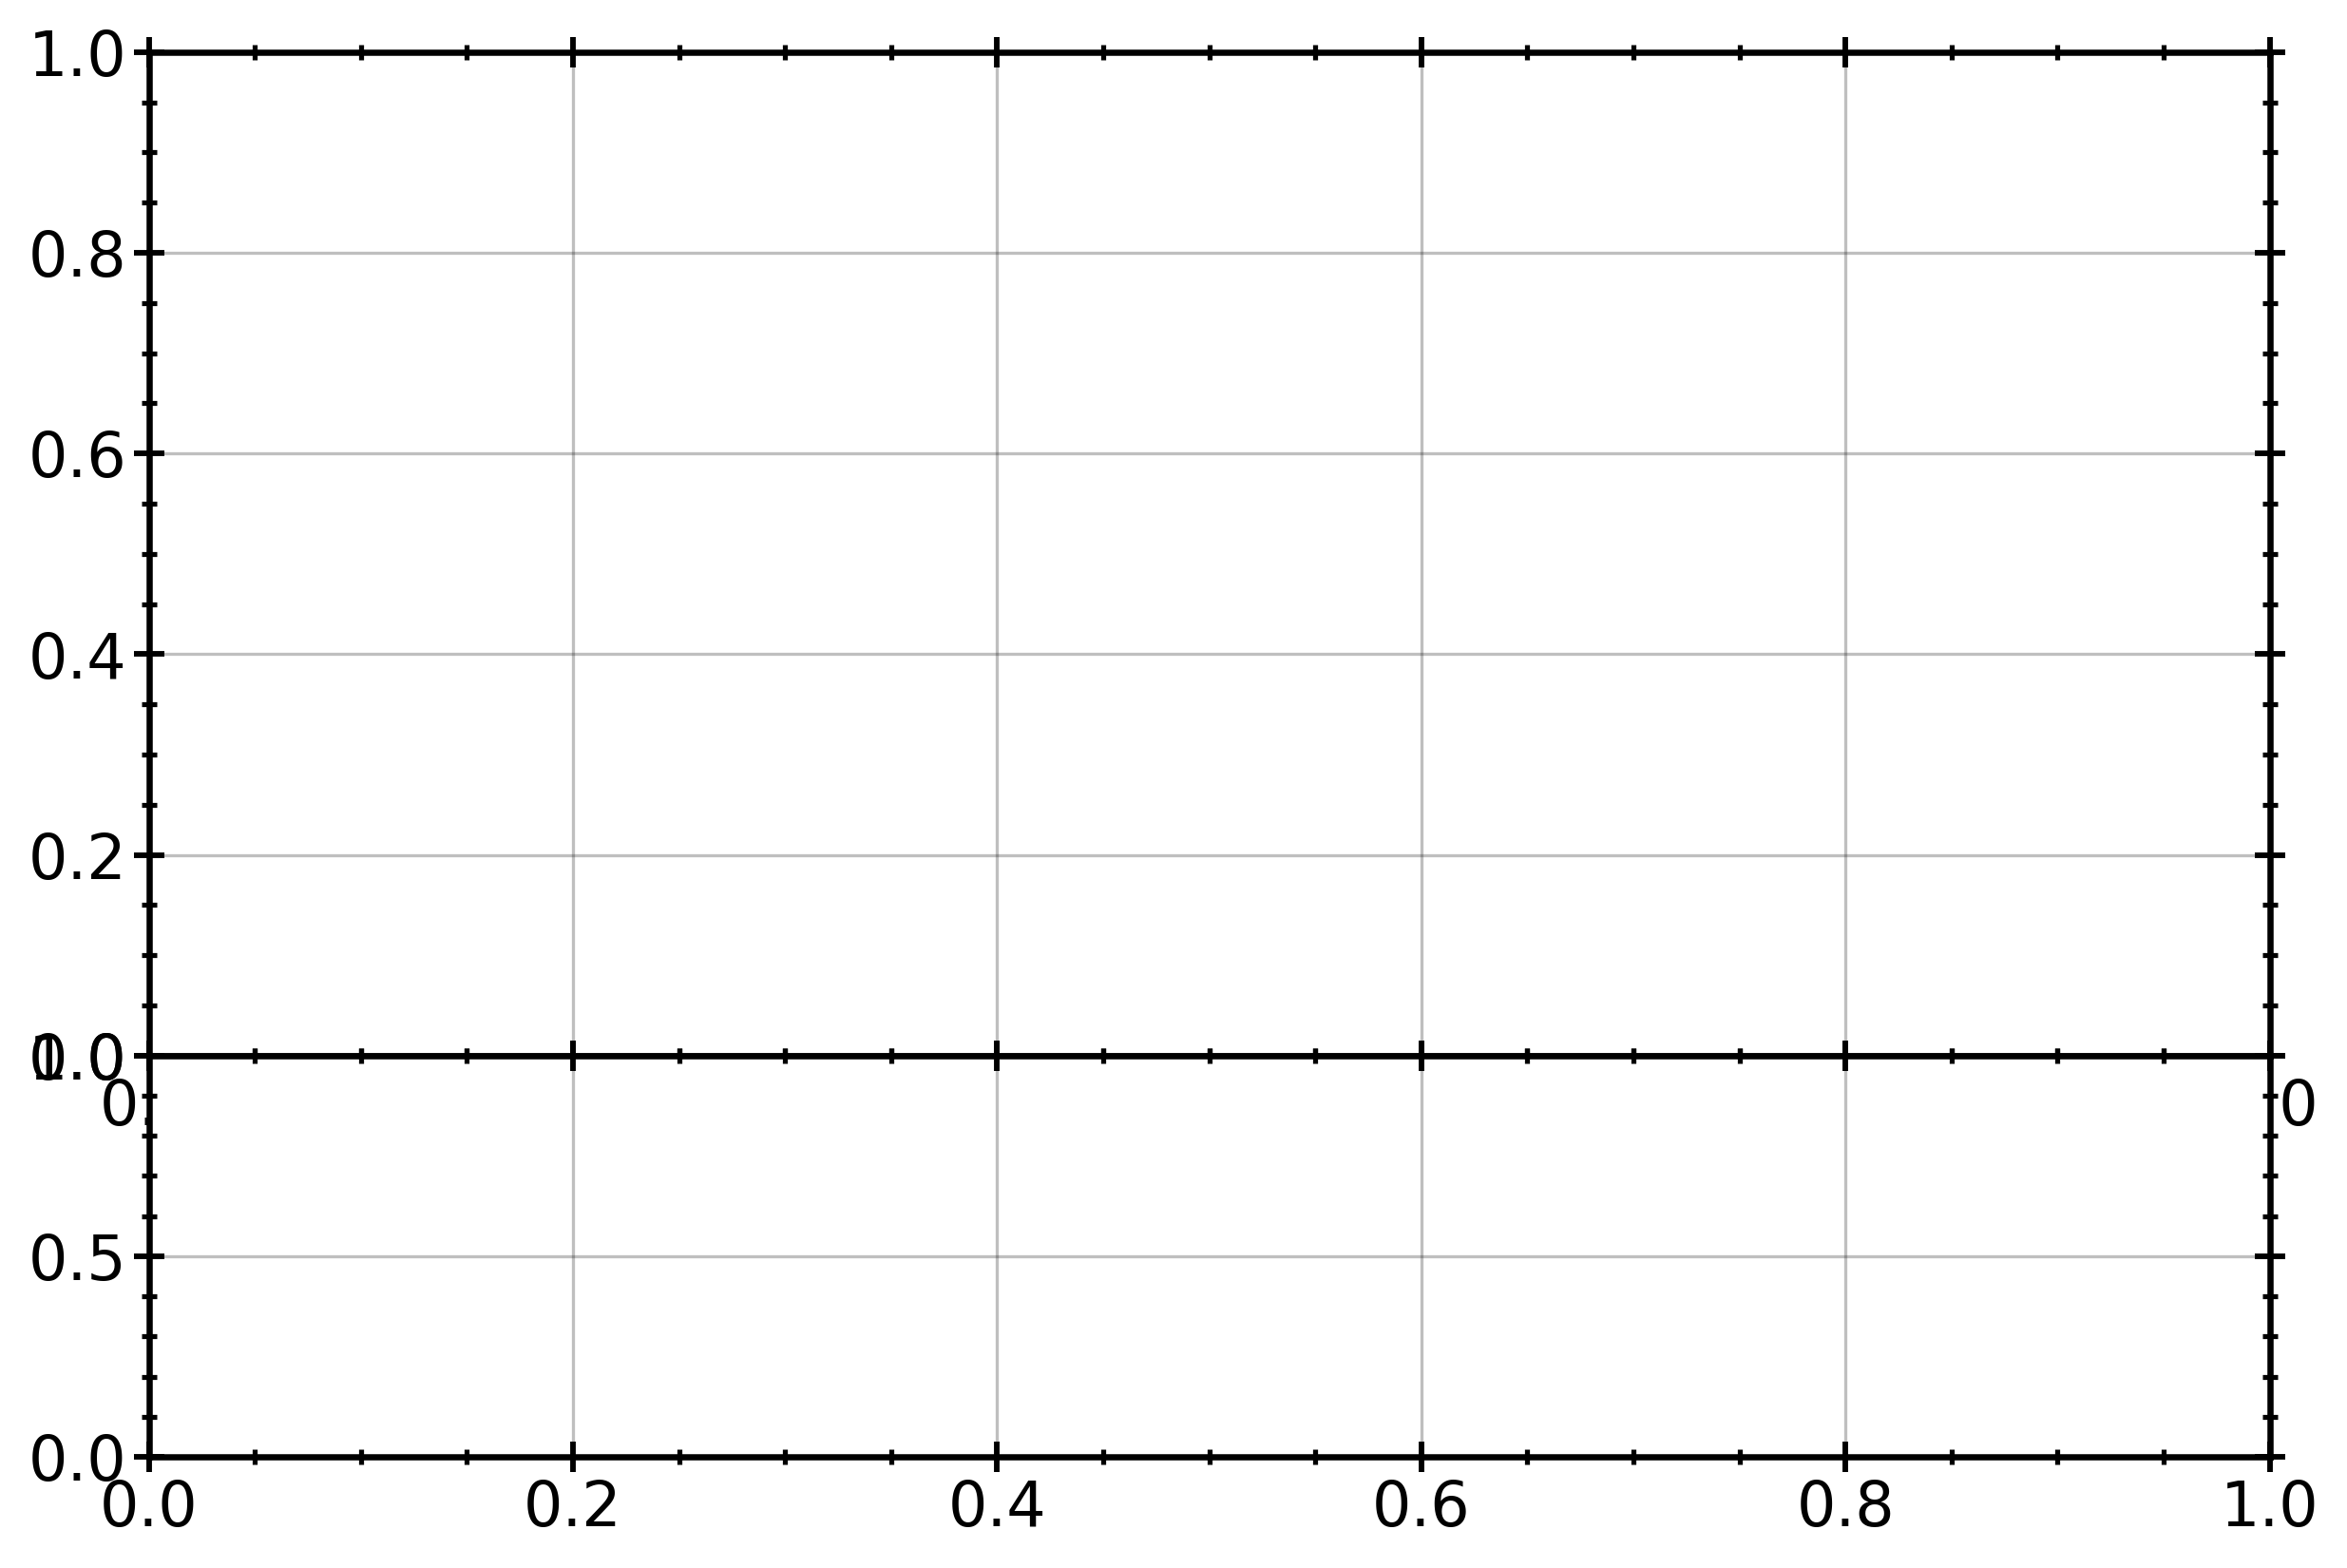

In [20]:
subplots = (2, 1)
fig_size = 1920
ratio = 1.5
ts = 2
Fig = Figure(fig_size=fig_size, subplots=subplots, 
             ratio=ratio, theme='default', 
             wspace=0.025, hspace=0.0, grid=True,
             ts=ts, height_ratios=[1,0.4])
fs = Fig.fs
ax1 = Fig.axes_flat[0]
ax2 = Fig.axes_flat[1]
lw = 0.35

cs = ['r', 'k']
legend_elements1 = []  # To store the legend handles for the first set
legend_elements2 = []  # To store the legend handles for the second set


labels1 = ['$\\rho_{\\text{rdm}}$ ($z=0$)', 
          '$\\rho_{\\text{grid}}$ ($z=0$)',]

labels2 = ['NFW fit $(\\rho_{\\text{rdm}})$', 
          'NFW fit $(\\rho_{\\text{grid}})$',]

for i, sim_type in enumerate(sim_types[:2]):

    r = dic_profile[sim_type]['r']
    density = dic_profile[sim_type]['density']
    density2 = dic_profile[sim_type]['density2']

    center = (edges[:-1] + edges[1:]) / 2

    vol_el = 4*np.pi*(r[1:]**3 - r[:-1]**3) / 3

    initial_rho_s, initial_r_s = np.log(density[0]), r[10]



    popt, pcov = curve_fit(ut.NFW_density_profile, r[:-1], np.log(density), p0=[initial_rho_s, initial_r_s],
                           maxfev=100000,
                           #bounds=([0, 0], [1e10, 50])
                           )
    
    fitted_rho_s, fitted_r_s = popt



    nfw_profile_arr = ut.NFW_density_profile(r[:-1], rho_s=fitted_rho_s, r_s=fitted_r_s,)

    # residual = density - nfw_profile_arr / vol_el

    line1 = ax1.bar(r[0:-1], density, label=labels1[i], color=cs[i], alpha=0.5,
                      lw=fs*lw*0, 
                      width=dr, 
                      )
    
    line2, = ax1.plot(r[:-1], nfw_profile_arr, label=f'{labels2[i]}', lw=lw*fs, c=cs[i], ls='--')

    # line1, = ax1.plot(rs[:-1], density2, label=labels1[i], color=cs[i], alpha=1,
    #                     lw=fs*lw, 
    #                     #width=dr, 
    #                     )
    
    x0, y0 = 0.025, 0.15
    dx, dy = .3, .1

    ax1.text(x0+i*dx, y0, f'$\\rho_s = {fitted_rho_s:.2e}$',
            fontsize=fs*ts, ha='left', va='center', transform=ax1.transAxes, color=cs[i])
    
    ax1.text(x0+i*dx, y0 - dy, f'$r_s = {fitted_r_s:.2e}$',
            fontsize=fs*ts, ha='left', va='bottom', transform=ax1.transAxes, color=cs[i])
    


    # ax2.plot(r, residual, label=f'{labels1[i]} - {labels2[i]}', lw=lw*fs, c=cs[i])

    # legend_elements1.append(line1)
    # legend_elements2.append(line2)

    print('done')

for ax in [ax1, ax2]:
    ax.set_xlim(1, r[-1])
    ax.set_yscale('log')
    ax.set_xscale('log')


ax1.tick_params(axis='x', labelcolor='w')

# # Creating the first legend with labels
# legend1 = ax.legend(handles=legend_elements1, fontsize=fs*ts, loc=(0.685, 0.805))
# ax1.add_artist(legend1)  # This is necessary to keep the first legend when the second is created

# # Creating the second legend with labels2, adjust the location as needed
# ax1.legend(handles=legend_elements2, fontsize=fs*ts, loc=(0.285, 0.805))


#ax2.set_ylim(1e-5, 1e10)
ax1.set_ylabel(r' $\log \rho$ [$\text{M}_{\! \odot} \, \text{kpc}^{-3}$]', fontsize=fs*ts)

ax2.set_ylabel(r' residual [$\text{M}_{\! \odot} \, \text{kpc}^{-3}$]', fontsize=fs*ts)
ax2.set_xlabel('$r$ [kpc]', fontsize=fs*ts)

savepath = f'../figures/{simulation_name}/figure_3.jpg'
Fig.save(savepath, bbox_inches='tight')
plt.close()

In [109]:
r

array([ 0.  ,  0.02,  0.04, ..., 19.96, 19.98, 20.  ])